Saved: acc_cifar10.svg
Saved: acc_cifar100.svg


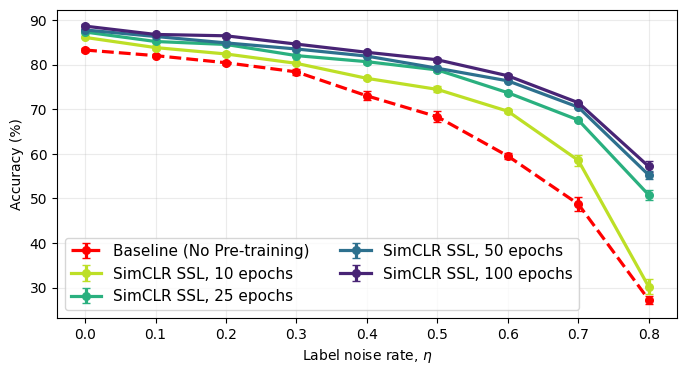

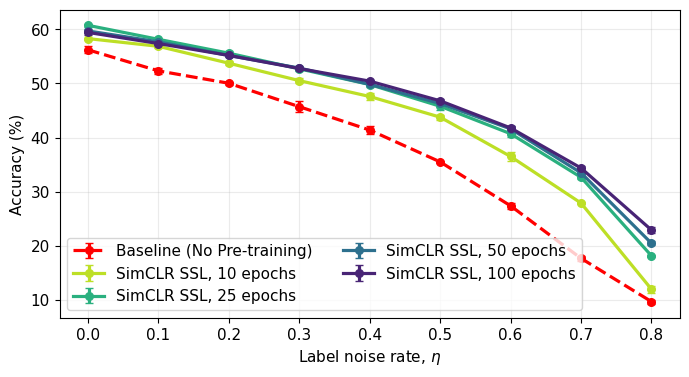

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- helpers ----------
def get_dataset(name: str):
    n = name.lower()
    if "cifar100" in n: return "cifar100"
    if "cifar10"  in n: return "cifar10"
    m = re.search(r"_c(\d+)", name, re.I)
    return f"c{m.group(1)}" if m else "unknown"

def get_pt_epochs(name: str, pretrain_field: int):
    m = re.search(r"_e(\d+)", name)
    return int(m.group(1)) if m else int(pretrain_field or 0)

def is_baseline(name: str):
    return name.lower().startswith("baseline")

def is_pretrained(name: str):
    n = name.lower()
    # extend as you add methods
    return n.startswith(("simclr","byol","simsiam","barlow"))
    
def get_pt_epochs(name: str, pretrain_field=None):
    n = name.lower()
    # explicit "preE-<k>" takes priority: simclr_cifar10_preE-5_supE-10...
    m = re.search(r"pre[e-]?[-_]?(\d+)", n)        # matches preE-5, pre-5, pree5
    if m: return int(m.group(1))
    # special-case pure SSL dirs like: simclr_cifar10_e100_s1
    if is_pretrained(n):
        m2 = re.search(r"(?:^|[_-])e(\d+)(?:$|[_-])", n)
        if m2: return int(m2.group(1))
    # fallback (rare): use provided field if any
    return int(pretrain_field or 0)

def strip_seed(name: str):
    """Remove seed pattern like '_s-1' or 's1' from experiment name."""
    return re.sub(r"[_-]s[-_]?\d+$", "", name)

def ci_get(df, names):
    if df is None or df.empty: return None
    if isinstance(names, str): names = [names]
    low = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return df[n]
        if n.lower() in low: return df[low[n.lower()]]
    return None

def get_ssl_method(name: str):
    n = str(name).lower()

    # more specific first
    if n.startswith("baseline-imagenet"):
        return "baseline-imagenet"

    for m in ("simclr", "byol", "simsiam", "barlow"):
        if n.startswith(m):
            return m

    if n.startswith("baseline"):
        return "baseline"

    return "unknown"

def extract_metrics_from_csv(csv_path: Path):
    if not csv_path.exists():
        return (None, None, None)
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return (None, None, None)
    acc_ser = ci_get(df, ["test_acc","val_acc","accuracy","acc","top1"])
    acc_val = None
    if acc_ser is not None:
        acc_val = pd.to_numeric(acc_ser, errors="coerce").dropna()
        if len(acc_val):
            acc_val = float(acc_val.iloc[-1])
            if acc_val <= 1.5:
                acc_val *= 100.0
    f1_ser = ci_get(df, ["cl_f1","f1","F1"])
    f1_val = None
    if f1_ser is not None:
        f1_vals = pd.to_numeric(f1_ser, errors="coerce").dropna()
        if len(f1_vals):
            f1_val = float(f1_vals.iloc[-1]) #* (100.0 if f1_vals.iloc[-1] <= 1.5 else 1.0)
    ba_ser = ci_get(df, ["cl_bal_acc","balanced_accuracy","bal_acc","BA"])
    ba_val = None
    if ba_ser is not None:
        ba_vals = pd.to_numeric(ba_ser, errors="coerce").dropna()
        if len(ba_vals):
            ba_val = float(ba_vals.iloc[-1]) * (100.0 if ba_vals.iloc[-1] <= 1.5 else 1.0)
    return (acc_val, f1_val, ba_val)

def aggregate_metric(df_in, metric):
    df = df_in.dropna(subset=[metric]).copy()

    # Ensure SSL_method exists (some callers may pass a filtered df without it)
    if "SSL_method" not in df.columns:
        def _infer_ssl(name: str):
            n = str(name).lower()
            if n.startswith("baseline-imagenet"):
                return "baseline-imagenet"
            for m in ("simclr", "byol", "simsiam", "barlow"):
                if n.startswith(m):
                    return m
            if n.startswith("baseline"):
                return "baseline"
            return "unknown"
        src = "exp" if "exp" in df.columns else ("exp_base" if "exp_base" in df.columns else None)
        df["SSL_method"] = df[src].map(_infer_ssl) if src else "unknown"

    g = (df.groupby(["dataset", "SSL_method", "noise", "pt_epochs"], as_index=False)[metric]
            .mean(numeric_only=True)
            .sort_values(["dataset", "SSL_method", "pt_epochs", "noise"]))
    return g

def aggregate_metric(df_in, metric):
    df = df_in.dropna(subset=[metric]).copy()

    # Ensure SSL_method exists (some callers may pass a filtered df without it)
    if "SSL_method" not in df.columns:
        def _infer_ssl(name: str):
            n = str(name).lower()
            if n.startswith("baseline-imagenet"):
                return "baseline-imagenet"
            for m in ("simclr", "byol", "simsiam", "barlow"):
                if n.startswith(m):
                    return m
            if n.startswith("baseline"):
                return "baseline"
            return "unknown"
        src = "exp" if "exp" in df.columns else ("exp_base" if "exp_base" in df.columns else None)
        df["SSL_method"] = df[src].map(_infer_ssl) if src else "unknown"

    g = df.groupby(["dataset", "SSL_method", "noise", "pt_epochs"])

    stats = (
        g[metric]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={
            "mean": metric,                  # keep same name for the mean
            "std":  f"{metric}_std",         # std dev column
            "count": "n_runs",               # how many seeds / runs
        })
    )
    stats[f"{metric}_stderr"] = stats[f"{metric}_std"] / np.sqrt(stats["n_runs"].clip(lower=1))


    # If you want standard *error* instead of std, you can add:
    # stats[f"{metric}_stderr"] = stats[f"{metric}_std"] / np.sqrt(stats["n_runs"].clip(lower=1))

    return stats



from matplotlib.lines import Line2D


def _plot_metric(agg_df, metric_name: str, ylabel: str):
    # Pretty names for legend
    pretty_method = {
        "baseline":          "Baseline (No Pre-training)",
        "baseline-imagenet": "Baseline (ImageNet)",
        "simclr":            "SimCLR",
        "byol":              "BYOL",
        "simsiam":           "SimSiam",
        "barlow":            "Barlow Twins",
    }

    for ds, g in agg_df.groupby("dataset"):
        plt.figure(figsize=(8, 4))


        #cmap = plt.cm.bwr_r
        cmap = plt.cm.coolwarm_r

        color = cmap(np.linspace(0.00, 0.00, 1))
        
        # --- Standard baseline (scratch) ---
        base_std = g[g["SSL_method"].str.lower() == "baseline"]
        if not base_std.empty:
            for method, gb in base_std.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                label = pretty_method.get(method.lower(), method)
                plt.plot(
                    gb["noise"],
                    gb[metric_name],
                    marker="o",
                    markersize=5,
                    linewidth=2.0,
                    color="red",
                    #color=color,
                    linestyle="--",
                    label=label
                )

        # --- Baseline-ImageNet ---
        base_im = g[g["SSL_method"].str.lower() == "baseline-imagenet"]
        if not base_im.empty:
            for method, gb in base_im.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                label = pretty_method.get(method.lower(), method)
                plt.plot(
                    gb["noise"],
                    gb[metric_name],
                    marker="o",
                    markersize=4,
                    linewidth=2.5,
                    linestyle="--",
                    label=label
                )

        # --- SSL lines (with pt epochs) ---
        nonbase = g[(g["pt_epochs"] > 0) & (~g["SSL_method"].str.lower().isin(["baseline","baseline-imagenet"]))]
        if not nonbase.empty:
            groups = sorted(
                nonbase.groupby(["SSL_method", "pt_epochs"]),
                key=lambda t: (t[0][0], t[0][1])
            )
            cmap = plt.cm.viridis
            
            colors = cmap(np.linspace(0.1, 0.9, len(groups)))

            for color, ((method, pe), sub) in zip(colors, groups):
                sub = sub.sort_values("noise")
                base_label = pretty_method.get(method.lower(), method)
                label = f"{base_label} (pt={pe})"
                plt.plot(
                    sub["noise"],
                    sub[metric_name],
                    marker="o",
                    markersize=5,
                    linewidth=2.0,
                    color=color,
                    label=label
                )

        # --- Final plot styling ---
        # X axis: label noise rate η
        plt.xlabel(r"Label noise rate, $\eta$")
        plt.ylabel(ylabel)
        
        plt.rcParams.update({
            "font.size": 11,
            "axes.labelsize": 11,
            "xtick.labelsize": 11,
            "ytick.labelsize": 11,
            "legend.fontsize": 11,
        })



        # Tick marks exactly at the corruption rates used
        xticks = sorted(g["noise"].dropna().unique())
        plt.xticks(xticks)

        plt.grid(True, alpha=0.25)
        # No legend title, no frame – cleaner for papers
        plt.legend(ncol=2, frameon=True)

        out_name = f"{metric_name}_{ds}.svg"
        plt.savefig(out_name, format="svg", bbox_inches="tight")
        print(f"Saved: {out_name}")
        
def _plot_metric(agg_df, metric_name: str, ylabel: str):
    # Map internal method names -> paper-ready legend labels
    METHOD_LABEL_MAP = {
        "baseline":          "Baseline (No Pre-training)",
        "baseline-imagenet": "Supervised (ImageNet init.)",
        "simclr":            "SimCLR SSL",
        "byol":              "BYOL SSL",
        "simsiam":           "SimSiam SSL",
        "barlow":            "Barlow Twins SSL",
    }

    def pretty_method_name(method: str) -> str:
        return METHOD_LABEL_MAP.get(method.lower(), method)

    def ssl_label(method: str, pt_epochs: int) -> str:
        base = pretty_method_name(method)
        # Short but clear; good for legends
        return f"{base}, {int(pt_epochs)} epochs"

    for ds, g in agg_df.groupby("dataset"):
        plt.figure(figsize=(8, 4))

        # --- Standard baseline (scratch) ---
        base_std = g[g["SSL_method"].str.lower() == "baseline"]
        if not base_std.empty:
            for method, gb in base_std.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                label = pretty_method_name(method)
                plt.plot(
                    gb["noise"],
                    gb[metric_name],
                    marker="o",
                    markersize=5.5,
                    linewidth=2.3,
                    color="red",
                    linestyle="--",
                    label=label,
                )

        # --- Baseline-ImageNet ---
        base_im = g[g["SSL_method"].str.lower() == "baseline-imagenet"]
        if not base_im.empty:
            for method, gb in base_im.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                label = pretty_method_name(method)
                plt.plot(
                    gb["noise"],
                    gb[metric_name],
                    marker="o",
                    markersize=4,
                    linewidth=2.5,
                    linestyle="--",
                    label=label,
                )

        # --- SSL lines (with pt epochs) ---
        nonbase = g[
            (g["pt_epochs"] > 0)
            & (~g["SSL_method"].str.lower().isin(["baseline", "baseline-imagenet"]))
        ]
        if not nonbase.empty:
            groups = sorted(
                nonbase.groupby(["SSL_method", "pt_epochs"]),
                key=lambda t: (t[0][0], t[0][1]),
            )
            cmap = plt.cm.viridis
            colors = cmap(np.linspace(0.1, 0.9, len(groups)))

            for color, ((method, pe), sub) in zip(colors, groups):
                sub = sub.sort_values("noise")
                label = ssl_label(method, pe)
                plt.plot(
                    sub["noise"],
                    sub[metric_name],
                    marker="o",
                    markersize=5.5,
                    linewidth=2.3,
                    color=color,
                    label=label,
                )

        # --- Final plot styling ---
        plt.xlabel(r"Label noise rate, $\eta$")
        plt.ylabel(ylabel)

        plt.ylim(0.63, 0.93)
        plt.rcParams.update({
            "font.size": 11,
            "axes.labelsize": 11,
            "xtick.labelsize": 11,
            "ytick.labelsize": 11,
            "legend.fontsize": 11,  # slightly smaller for long labels
        })

        xticks = sorted(g["noise"].dropna().unique())
        plt.xticks(xticks)

        plt.grid(True, alpha=0.25)
        plt.legend(ncol=2, frameon=True)

        out_name = f"{metric_name}_{ds}.svg"
        plt.savefig(out_name, format="svg", bbox_inches="tight")
        print(f"Saved: {out_name}")

def _plot_metric(agg_df, metric_name: str, ylabel: str):
    # Map internal method names -> paper-ready legend labels
    METHOD_LABEL_MAP = {
        "baseline":          "Baseline (No Pre-training)",
        "baseline-imagenet": "Supervised (ImageNet init.)",
        "simclr":            "SimCLR SSL",
        "byol":              "BYOL SSL",
        "simsiam":           "SimSiam SSL",
        "barlow":            "Barlow Twins SSL",
    }

    def pretty_method_name(method: str) -> str:
        return METHOD_LABEL_MAP.get(method.lower(), method)

    def ssl_label(method: str, pt_epochs: int) -> str:
        base = pretty_method_name(method)
        return f"{base}, {int(pt_epochs)} epochs"

    std_col = f"{metric_name}_std"
    std_col = f"{metric_name}_stderr"

    
    for ds, g in agg_df.groupby("dataset"):
        plt.figure(figsize=(8, 4))

        # --- Standard baseline (scratch) ---
        base_std = g[g["SSL_method"].str.lower() == "baseline"]
        if not base_std.empty:
            for method, gb in base_std.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                label = pretty_method_name(method)
                y = gb[metric_name]
                yerr = gb[std_col].fillna(0.0) if std_col in gb else None

                plt.errorbar(
                    gb["noise"],
                    y,
                    yerr=yerr,
                    marker="o",
                    markersize=5.5,
                    linewidth=2.3,
                    color="red",
                    linestyle="--",
                    capsize=3,
                    label=label,
                )

        # --- Baseline-ImageNet ---
        base_im = g[g["SSL_method"].str.lower() == "baseline-imagenet"]
        if not base_im.empty:
            for method, gb in base_im.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                label = pretty_method_name(method)
                y = gb[metric_name]
                yerr = gb[std_col].fillna(0.0) if std_col in gb else None

                plt.errorbar(
                    gb["noise"],
                    y,
                    yerr=yerr,
                    marker="o",
                    markersize=4,
                    linewidth=2.5,
                    linestyle="--",
                    capsize=3,
                    label=label,
                )

        # --- SSL lines (with pt epochs) ---
        nonbase = g[
            (g["pt_epochs"] > 0)
            & (~g["SSL_method"].str.lower().isin(["baseline", "baseline-imagenet"]))
        ]
        if not nonbase.empty:
            groups = sorted(
                nonbase.groupby(["SSL_method", "pt_epochs"]),
                key=lambda t: (t[0][0], t[0][1]),
            )
            cmap = plt.cm.viridis_r
            colors = cmap(np.linspace(0.1, 0.9, len(groups)))

            for color, ((method, pe), sub) in zip(colors, groups):
                sub = sub.sort_values("noise")
                label = ssl_label(method, pe)
                y = sub[metric_name]
                yerr = sub[std_col].fillna(0.0) if std_col in sub else None

                plt.errorbar(
                    sub["noise"],
                    y,
                    yerr=yerr,
                    marker="o",
                    markersize=5.5,
                    linewidth=2.3,
                    color=color,
                    capsize=3,
                    label=label,
                )

        # --- Final plot styling ---
        plt.xlabel(r"Label noise rate, $\eta$")
        plt.ylabel(ylabel)

        #plt.ylim(0.63, 0.93)
        plt.rcParams.update({
            "font.size": 11,
            "axes.labelsize": 11,
            "xtick.labelsize": 11,
            "ytick.labelsize": 11,
            "legend.fontsize": 11,
        })

        xticks = sorted(g["noise"].dropna().unique())
        plt.xticks(xticks)

        plt.grid(True, alpha=0.25)
        plt.legend(ncol=2, frameon=True)

        out_name = f"{metric_name}_{ds}.svg"
        plt.savefig(out_name, format="svg", bbox_inches="tight")
        print(f"Saved: {out_name}")


# ---------- main function ----------
def plot_corruption_curves_for_dataset(dataset: str,
                                       ssl_method: str,
                                       base_dir: Path = Path.cwd(),
                                       results_dir_prefix: str = "results_",
                                       use_acc="best"):
    """
    Scan results_{dataset} for experiment folders, parse/aggregate metrics, and plot curves.
    Returns (agg_acc, agg_f1, agg_ba) as DataFrames.
    """
    ds_key = dataset.lower()
    root = base_dir / f"{results_dir_prefix}{ds_key}"

    # Build results table from folders
    rows = []
    if root.exists():
        for d in sorted(root.glob("*")):
            if not d.is_dir():
                continue
            csv, log = d/"metrics.csv", d/"logs.txt"
    
            acc, f1, bal_acc = extract_metrics_from_csv(csv)
            
            if use_acc == "best":
                if acc is None and log.exists():
                    try:
                        txt = log.read_text(errors="ignore")
                        m = re.search(r"Final.*Acc.*?([0-9]+(?:\.[0-9]+)?)\s*%", txt, re.I)
                        if m: acc = float(m.group(1))
                    except:
                        pass
                if acc is None and f1 is None and bal_acc is None:
                    continue
                
            if use_acc == "last":
                if acc is None and log.exists():
                    try:
                        txt = log.read_text(errors="ignore")
                        # Grab ALL Test(clean)Acc=<num>% occurrences and take the last one
                        matches = re.findall(r"Test\(clean\)Acc=([0-9]+(?:\.[0-9]+)?)\s*%", txt)
                        if matches:
                            acc = float(matches[-1])
                    except Exception:
                        pass
            
            m_noise = re.search(r"noise[-_= ]?(\d*\.?\d+)", d.name, re.I)
            noise = float(m_noise.group(1)) if m_noise else np.nan
            if noise > 1: noise /= 100.0  # accept 50 -> 0.5
    
            rows.append({
                "exp": d.name,
                "noise": noise,
                "acc": acc,
                "f1": f1,
                "bal_acc": bal_acc
            })
    results = pd.DataFrame(rows)
    if results.empty:
        print(f"No results to plot for dataset '{dataset}'. Looked in: {root}")
        return (pd.DataFrame(), pd.DataFrame(), pd.DataFrame())

    # Clean/derive fields
    df = results.copy()
    for col in ["noise","acc","f1","bal_acc"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    df["dataset"] = df["exp"].astype(str).map(get_dataset)
    df["pt_epochs"] = [get_pt_epochs(n, None) for n in df["exp"].astype(str)]
    df["is_baseline"] = df["exp"].str.lower().str.startswith("baseline")
    df.loc[df["is_baseline"], "pt_epochs"] = 0
    df["is_pretrained"] = df["exp"].astype(str).map(is_pretrained)
    df["SSL_method"] = df["exp"].astype(str).map(get_ssl_method)

    df.loc[df["is_baseline"], "pt_epochs"] = 0
    df["dataset"] = df["dataset"].fillna("unknown")

    #df_temp = df[df["noise"].isin([0.9])]
    #print(df_temp)


    """
    # --- Group by experiment type (average over seeds) ---
    df["exp_base"] = df["exp"].map(strip_seed)
    group_cols = ["exp_base", "dataset", "noise", "pt_epochs"]
    metric_cols = ["acc", "f1", "bal_acc"]
    g = df.groupby(group_cols, as_index=False)
    # means over seeds
    df_means  = g[metric_cols].mean(numeric_only=True)
    # number of seeds aggregated per group
    df_counts = g.size().rename(columns={"size": "n_seeds"})
    # combine
    df_grouped = df_means.merge(df_counts, on=group_cols, how="left")
    # Replace exp with the seedless version for plotting
    df = df_grouped.rename(columns={"exp_base": "exp"})
    """
    #print(df)
    
    # Metric-specific filtering of pretrain epochs (optional)
    df_acc = df.copy()
    df_f1  = df.copy()
    df_ba  = df.copy()

    # Metric-specific filtering of pretrain epochs
    df_acc = df[~df["pt_epochs"].isin([1, 5, 75])]
    df_acc = df_acc[~df_acc["noise"].isin([0.9])]
    df_f1 = df[~df["pt_epochs"].isin([1, 2, 5, 75])]
    df_f1 = df_f1[~df_f1["noise"].isin([0.0, 0.9])]
    df_ba = df[~df["pt_epochs"].isin([1, 2])]
    df_ba = df_ba[~df_ba["noise"].isin([0.0, 0.9])]


    #df_acc = df.copy()
    #df_f1  = df.copy()
    #df_ba  = df.copy()
    
    # Aggregate
    agg_acc = aggregate_metric(df_acc, "acc")
    agg_f1  = aggregate_metric(df_f1,  "f1")
    agg_ba  = aggregate_metric(df_ba,  "bal_acc")
    

    
    #agg_acc = agg_acc[agg_acc["SSL_method"].isin(['baseline', 'baseline-imagenet', ssl_method])]
    agg_acc = agg_acc[agg_acc["SSL_method"].isin(['baseline', ssl_method])]
    #agg_f1  = agg_f1[agg_f1["SSL_method"].isin(['baseline', 'baseline-imagenet', ssl_method])]
    agg_f1  = agg_f1[agg_f1["SSL_method"].isin(['baseline', ssl_method])]
    agg_ba  = agg_ba[agg_ba["SSL_method"].isin(['baseline', 'baseline-imagenet', ssl_method])]


    """
    df_temp = df[df["SSL_method"].isin(['baseline-imagenet'])]
    df_temp = df_temp[~df_temp["noise"].isin([0.9])]
    print(df_temp)
    """


    # Plot
    if not agg_acc.empty: _plot_metric(agg_acc, "acc", "Accuracy (%)")
    #if not agg_f1.empty:  _plot_metric(agg_f1,  "f1",  "F1" + (" Score" if agg_f1["f1"].max() and agg_f1["f1"].max()>1.5 else ""))
    #if not agg_f1.empty:  _plot_metric(agg_f1,  "f1",  "F1" + (" Score"))
    #if not agg_ba.empty:  _plot_metric(agg_ba,  "bal_acc", "Balanced Accuracy" + (" (%)" if agg_ba["bal_acc"].max() and agg_ba["bal_acc"].max()>1.5 else ""))

    return agg_acc, agg_f1, agg_ba



agg10_acc, agg10_f1, agg10_ba  = plot_corruption_curves_for_dataset("cifar10", "simclr")
#agg10_acc, agg10_f1, agg10_ba  = plot_corruption_curves_for_dataset("cifar10", "barlow")
agg100_acc, agg100_f1, agg100_ba = plot_corruption_curves_for_dataset("cifar100", "simclr")

Saved: acc_cifar10.svg
Saved: acc_cifar100.svg


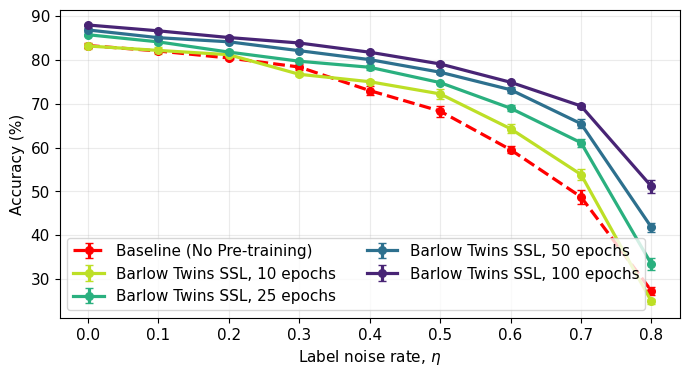

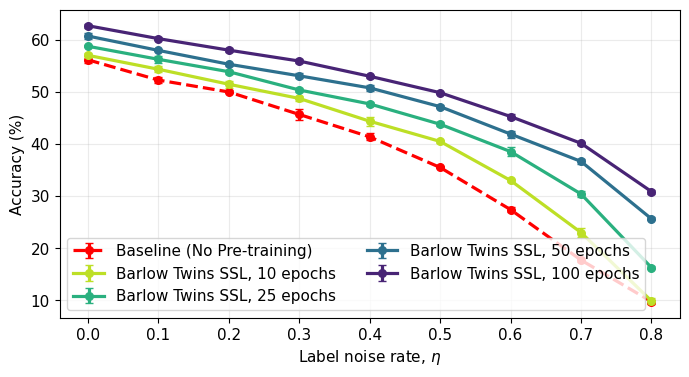

In [2]:
a2agg10_acc, a2agg10_f1, a2agg10_ba = plot_corruption_curves_for_dataset("cifar10", "barlow")
a2agg100_acc, a2agg100_f1, a2agg100_ba = plot_corruption_curves_for_dataset("cifar100", "barlow")

In [3]:
# -----------------------------
# Build LaTeX tables from agg_* 
# -----------------------------
import textwrap

# Combine CIFAR-10 and CIFAR-100 aggregated results
agg_acc_all = pd.concat([agg10_acc, agg100_acc], ignore_index=True)
agg_f1_all  = pd.concat([agg10_f1,  agg100_f1 ], ignore_index=True)
agg_ba_all  = pd.concat([agg10_ba,  agg100_ba ], ignore_index=True)

agg_acc_all = pd.concat([agg10_acc, agg100_acc, a2agg10_acc, a2agg100_acc], ignore_index=True)
agg_f1_all  = pd.concat([agg10_f1, agg100_f1, a2agg10_f1, a2agg100_f1], ignore_index=True)
agg_ba_all  = pd.concat([agg10_ba, agg100_ba, a2agg10_ba, a2agg100_ba], ignore_index=True)

# Helper: map internal dataset/method names to pretty LaTeX names
DATASET_PRETTY = {
    "cifar10":  "CIFAR-10",
    "cifar100": "CIFAR-100",
}
METHOD_PRETTY_MAIN = {
    "baseline":          "Baseline",
    "simclr":            "SimCLR",
    "barlow":           "Barlow Twins",
}
METHOD_PRETTY_IMAGENET = {
    "baseline":          "Baseline",
    "baseline-imagenet": "ImageNet Pretrained",
    # "ssl_pretrained" row in the second table will use a generic name
}

# Noise values (corruption rates) to show in the tables
NOISE_LEVELS = [0.0, 0.2, 0.4, 0.6, 0.8]


def _get_metric_value(agg_df, dataset, ssl_method, noise, metric_name, pt_target=None):
    """
    Pull a single metric value from an aggregated DF.
    - dataset: 'cifar10' / 'cifar100'
    - ssl_method: 'baseline', 'simclr', 'barlow', 'baseline-imagenet', ...
    - noise: float corruption rate
    - metric_name: 'acc', 'f1', 'bal_acc'
    - pt_target: preferred pt_epochs (e.g., 100 for SSL methods)
    Returns a float or None if not found.
    """
    # match noise robustly (float rounding)
    mask = (
        (agg_df["dataset"] == dataset) &
        (agg_df["SSL_method"].str.lower() == ssl_method.lower()) &
        (agg_df["noise"].round(3) == round(float(noise), 3))
    )
    sub = agg_df[mask].copy()

    if sub.empty:
        return None

    # If a target pt_epochs is requested, prefer it
    if pt_target is not None and "pt_epochs" in sub.columns:
        sub_target = sub[sub["pt_epochs"] == pt_target]
        if not sub_target.empty:
            sub = sub_target

    # otherwise, or if the target isn't found, use the largest pt_epochs
    if "pt_epochs" in sub.columns and len(sub) > 1:
        sub = sub.sort_values("pt_epochs").iloc[-1]
    else:
        sub = sub.iloc[0]

    val = sub.get(metric_name, None)
    if pd.isna(val):
        return None
    return float(val)


def format_val(v):
    """Format numeric values as 'xx.xx'; missing -> '--'."""
    if v is None:
        return "--"
    return f"{v:.2f}"


# ========================================================
# 1) Main CIFAR-10 / CIFAR-100 table (Acc, F1, BA vs noise)
# ========================================================

def build_main_results_table():
    # New header matching your desired structure
    lines = []
    header = r"""
\begin{table*}[!b]
\centering
\caption{XXX.}
\label{tab:Main_results}
\resizebox{\textwidth}{!}{
\begin{tabular}{llc|ccc|ccc|ccc|ccc}
\toprule
\multirow{2}{*}{\textbf{Dataset}} &
\multirow{2}{*}{\textbf{Method}} &
\multicolumn{1}{c|}{$\eta=0.0$} &
\multicolumn{3}{c|}{$\eta=0.2$} &
\multicolumn{3}{c|}{$\eta=0.4$} &
\multicolumn{3}{c|}{$\eta=0.6$} &
\multicolumn{3}{c}{$\eta=0.8$} \\
\cmidrule(lr){3-15}
 &  & Acc & Acc & F1 & BA & Acc & F1 & BA & Acc & F1 & BA & Acc & F1 & BA \\
\midrule
""".strip("\n")
    lines.append(header)

    # noise levels (η) to show; η=0.0 is special (Acc only)
    NOISE_LEVELS = [0.0, 0.2, 0.4, 0.6, 0.8]
    methods = ["baseline", "simclr", "barlow"]

    for ds in ["cifar10", "cifar100"]:
        # --- 1) Collect numeric values for this dataset, for all methods ---
        # For each method we build a list of 13 cells:
        # [η=0.0 Acc,
        #  η=0.2 Acc, F1, BA,
        #  η=0.4 Acc, F1, BA,
        #  η=0.6 Acc, F1, BA,
        #  η=0.8 Acc, F1, BA]
        numeric_rows = {}

        for method in methods:
            vals = []

            # pt_epochs choice: baseline -> 0, SSL -> 100
            def _pt_target(m):
                return 0 if m == "baseline" else 100

            # η = 0.0 : Acc only
            pt_t = _pt_target(method)
            acc_0 = _get_metric_value(
                agg_acc_all, ds, method, 0.0, "acc", pt_target=pt_t
            )
            vals.append(acc_0)

            # η > 0 : Acc, F1, BA
            for eta in [0.2, 0.4, 0.6, 0.8]:
                acc = _get_metric_value(
                    agg_acc_all, ds, method, eta, "acc", pt_target=pt_t
                )
                f1 = _get_metric_value(
                    agg_f1_all, ds, method, eta, "f1", pt_target=pt_t
                )
                ba_raw = _get_metric_value(
                    agg_ba_all, ds, method, eta, "bal_acc", pt_target=pt_t
                )
                # convert BA from XX.XX (%) to 0.XX
                ba = ba_raw / 100.0 if ba_raw is not None else None
                vals.extend([acc, f1, ba])

            numeric_rows[method] = vals

        # --- 2) Compute column-wise maxima (per dataset) for bolding ---
        num_cols = len(next(iter(numeric_rows.values())))  # should be 13
        col_max = []
        for c in range(num_cols):
            col_vals = [
                numeric_rows[m][c]
                for m in methods
                if numeric_rows[m][c] is not None
            ]
            col_max.append(max(col_vals) if col_vals else None)

        # --- 3) Emit rows with bolded maxima ---
        # Use \multirow{3}{*}{<Dataset>} for the first row of each dataset
        first_row = True
        for method in methods:
            pretty_method = METHOD_PRETTY_MAIN[method]
            vals = numeric_rows[method]
            cell_strs = []

            for c, v in enumerate(vals):
                if v is None:
                    s = "--"
                else:
                    formatted = f"{v:.2f}"
                    # bold if this is the maximum for this column within the dataset
                    if col_max[c] is not None and v == col_max[c]:
                        s = r"\textbf{" + formatted + "}"
                    else:
                        s = formatted
                cell_strs.append(s)

            if first_row:
                dataset_cell = r"\multirow{3}{*}{" + DATASET_PRETTY[ds] + "}"
                row = (
                    dataset_cell
                    + " & "
                    + pretty_method
                    + " & "
                    + " & ".join(cell_strs)
                    + r" \\"
                )
                first_row = False
            else:
                row = (
                    " & "
                    + pretty_method
                    + " & "
                    + " & ".join(cell_strs)
                    + r" \\"
                )

            lines.append(row)

        # midrule between CIFAR-10 and CIFAR-100 sections
        if ds == "cifar10":
            lines.append(r"\midrule")

    footer = r"""
\bottomrule
\end{tabular}
}
\end{table*}
""".strip("\n")
    lines.append(footer)

    return "\n".join(lines)



# ===================================================
# 2) ImageNet vs SSL vs Baseline table (Accuracy only)
# ===================================================

def build_imagenet_vs_ssl_table(
    ssl_method_name="simclr",
    ssl_row_label="SSL Pretrained",
    dataset="cifar10",
    ssl_pt_epochs=100,      # <-- NEW: choose which pretrain epoch(s) to use
):
    """
    Build the LaTeX for the ImageNet vs SSL vs Baseline accuracy-only table.
    - ssl_method_name: 'simclr' or 'barlow'
    - ssl_row_label: how the SSL row appears in the table
    - dataset: 'cifar10' or 'cifar100'
    - ssl_pt_epochs: int or list of ints (e.g. 25, 50, 100, [50,100])
    """

    # Normalize input to list
    if isinstance(ssl_pt_epochs, int):
        ssl_pt_epochs = [ssl_pt_epochs]

    # Prefer highest available pt_epochs
    preferred_pt = max(ssl_pt_epochs)

    def pick_pt(agg_df, ds, method, eta):
        """Return the metric using the *highest available* pt_epochs from the list."""
        subset = agg_df[
            (agg_df["dataset"] == ds)
            & (agg_df["SSL_method"].str.lower() == method.lower())
            & (agg_df["noise"].round(3) == round(float(eta), 3))
            & (agg_df["pt_epochs"].isin(ssl_pt_epochs))  # filter to chosen epochs
        ]
        if subset.empty:
            return None
        # pick max pt_epochs available
        row = subset.sort_values("pt_epochs").iloc[-1]
        return float(row["acc"]) if not pd.isna(row["acc"]) else None

    # Build LaTeX
    lines = []
    header = r"""
\begin{table}[H]
\centering
\caption{XXX.}
\label{tab:imagenet_pretrain}
\resizebox{\columnwidth}{!}{
\begin{tabular}{lccccc}
\toprule
\multirow{2}{*}{\textbf{Method}} & \multicolumn{5}{c}{\textbf{Accuracy (\%)}} \\
\cmidrule(lr){2-6}
 & $\eta=0.0$ & $\eta=0.2$ & $\eta=0.4$ & $\eta=0.6$ & $\eta=0.8$ \\
\midrule
""".strip("\n")
    lines.append(header)

    NOISE_LEVELS = [0.0, 0.2, 0.4, 0.6, 0.8]

    # Baseline (pt=0)
    base_vals = [
        format_val(_get_metric_value(agg_acc_all, dataset, "baseline", eta, "acc", pt_target=0))
        for eta in NOISE_LEVELS
    ]
    lines.append("Baseline             & " + " & ".join(base_vals) + r" \\")

    # ImageNet (pt=0)
    im_vals = [
        format_val(_get_metric_value(agg_acc_all, dataset, "baseline-imagenet", eta, "acc", pt_target=0))
        for eta in NOISE_LEVELS
    ]
    lines.append("ImageNet Pretrained  & " + " & ".join(im_vals) + r" \\")

    # SSL Pretrained (use selected pt_epochs)
    ssl_vals = [
        format_val(pick_pt(agg_acc_all, dataset, ssl_method_name, eta))
        for eta in NOISE_LEVELS
    ]
    lines.append(f"{ssl_row_label}       & " + " & ".join(ssl_vals) + r"\\")

    footer = r"""
\bottomrule
\end{tabular}
}
\end{table}
""".strip("\n")
    lines.append(footer)

    return "\n".join(lines)



# ==================
# Generate the tables
# ==================

latex_main = build_main_results_table()

# For the ImageNet comparison table, choose which SSL method you want to showcase:
#   - ssl_method_name="simclr", ssl_row_label="SimCLR (SSL Pretrained)"
#   - ssl_method_name="barlow", ssl_row_label="Barlow Twins (SSL Pretrained)"
latex_imagenet = build_imagenet_vs_ssl_table(
    ssl_method_name="simclr",
    ssl_row_label="SSL Pretrained",
    dataset="cifar10",   # or "cifar100" if you prefer
)

print("===== Main CIFAR-10/100 Table =====")
print(latex_main)
print("\n\n===== ImageNet vs SSL Table =====")
print(latex_imagenet)




===== Main CIFAR-10/100 Table =====
\begin{table*}[!b]
\centering
\caption{XXX.}
\label{tab:Main_results}
\resizebox{\textwidth}{!}{
\begin{tabular}{llc|ccc|ccc|ccc|ccc}
\toprule
\multirow{2}{*}{\textbf{Dataset}} &
\multirow{2}{*}{\textbf{Method}} &
\multicolumn{1}{c|}{$\eta=0.0$} &
\multicolumn{3}{c|}{$\eta=0.2$} &
\multicolumn{3}{c|}{$\eta=0.4$} &
\multicolumn{3}{c|}{$\eta=0.6$} &
\multicolumn{3}{c}{$\eta=0.8$} \\
\cmidrule(lr){3-15}
 &  & Acc & Acc & F1 & BA & Acc & F1 & BA & Acc & F1 & BA & Acc & F1 & BA \\
\midrule
\multirow{3}{*}{CIFAR-10} & Baseline & 83.27 & 80.42 & 0.80 & 0.91 & 73.00 & 0.85 & 0.87 & 59.50 & 0.83 & 0.79 & 27.28 & 0.73 & 0.61 \\
 & SimCLR & \textbf{88.63} & \textbf{86.46} & \textbf{0.84} & \textbf{0.93} & \textbf{82.76} & \textbf{0.90} & \textbf{0.92} & \textbf{77.50} & \textbf{0.91} & \textbf{0.88} & \textbf{57.16} & \textbf{0.76} & \textbf{0.73} \\
 & Barlow Twins & 87.95 & 85.09 & 0.83 & 0.92 & 81.74 & 0.89 & 0.91 & 74.89 & 0.90 & 0.87 & 51.12 & 0.75 & 0.71 

In [4]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

# -----------------------
# Helper functions
# -----------------------

def get_dataset(name: str):
    n = name.lower()
    if "cifar100" in n: return "cifar100"
    if "cifar10" in n:  return "cifar10"
    m = re.search(r"_c(\d+)", name, re.I)
    return f"c{m.group(1)}" if m else "unknown"


def get_ssl_method(name: str):
    n = str(name).lower()

    if n.startswith("baseline-imagenet"):
        return "baseline-imagenet"

    for m in ("simclr", "byol", "simsiam", "barlow"):
        if n.startswith(m):
            return m

    if n.startswith("baseline"):
        return "baseline"

    return "unknown"


def get_pt_epochs(name: str, pretrain_field=None):
    n = name.lower()
    m = re.search(r"pre[e-]?[-_]?(\d+)", n)  # matches preE100, pre-100, pre100
    if m:
        return int(m.group(1))
    for mname in ("simclr", "byol", "simsiam", "barlow"):
        if n.startswith(mname):
            m2 = re.search(r"(?:^|[_-])e(\d+)(?:$|[_-])", n)
            if m2: return int(m2.group(1))
    return int(pretrain_field or 0)


def ci_get(df, names):
    """Case-insensitive column lookup."""
    if df is None or df.empty:
        return None
    if isinstance(names, str):
        names = [names]
    low = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns:
            return df[n]
        if n.lower() in low:
            return df[low[n.lower()]]
    return None


def extract_acc_from_csv(csv_path: Path):
    """Last accuracy value from metrics.csv, normalizing to % if needed."""
    if not csv_path.exists():
        return None
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return None

    acc_ser = ci_get(df, ["test_acc", "val_acc", "accuracy", "acc", "top1"])
    if acc_ser is None:
        return None

    acc_vals = pd.to_numeric(acc_ser, errors="coerce").dropna()
    if acc_vals.empty:
        return None

    acc_val = float(acc_vals.iloc[-1])
    if acc_val <= 1.5:
        acc_val *= 100.0
    return acc_val


def extract_seed_from_exp(exp_name: str):
    """Extract the last digit of the folder name as seed."""
    last = exp_name.strip()[-1]
    return int(last) if last.isdigit() else None


# -------------------------------------------------
# NEW: Parse method_filter like "simclr_preE100"
# -------------------------------------------------

def parse_method_filter(method_filter: str):
    """
    Examples:
        "baseline-imagenet" → method="baseline-imagenet", pt=None
        "simclr_preE100"   → method="simclr", pt=100
        "barlow_preE50"    → method="barlow", pt=50
    """
    mf = method_filter.lower()

    # If it's baseline-based:
    if mf.startswith("baseline-imagenet"):
        return "baseline-imagenet", None
    if mf.startswith("baseline"):
        return "baseline", None

    # SSL cases:
    for method in ("simclr", "byol", "simsiam", "barlow"):
        if mf.startswith(method):
            m = re.search(r"pree?(\d+)", mf)
            pt = int(m.group(1)) if m else None
            return method, pt

    # fallback
    return method_filter.lower(), None


# -------------------------------------------------
# Main collector
# -------------------------------------------------

def collect_rows_for_dataset(
    dataset: str,
    method_filter: str,
    base_dir: Path = Path.cwd(),
    results_dir_prefix: str = "results_",
    noise_filter=None,
):
    """
    Collects per-seed rows for a specific method:
        method_filter = "baseline-imagenet"
        method_filter = "simclr_preE100"
        method_filter = "barlow_preE50", etc.
    """
    # Parse
    target_method, target_pt = parse_method_filter(method_filter)

    root = base_dir / f"{results_dir_prefix}{dataset.lower()}"
    rows = []

    for d in sorted(root.glob("*")):
        if not d.is_dir():
            continue

        exp = d.name
        ssl_method = get_ssl_method(exp)
        pt_epochs = get_pt_epochs(exp)

        # Method must match
        if ssl_method != target_method:
            continue

        # If pretrain epoch specified, enforce it
        if target_pt is not None and pt_epochs != target_pt:
            continue

        # Extract accuracy
        acc = extract_acc_from_csv(d / "metrics.csv")
        if acc is None:
            continue

        # Extract noise
        m_noise = re.search(r"noise[-_= ]?(\d*\.?\d+)", exp, re.I)
        noise = float(m_noise.group(1)) if m_noise else np.nan
        if noise > 1:
            noise /= 100.0

        # Filter by noise if desired
        if noise_filter is not None:
            allowed = {round(float(x), 3) for x in noise_filter}
            if round(noise, 3) not in allowed:
                continue

        seed = extract_seed_from_exp(exp)

        rows.append({
            "dataset": dataset.lower(),
            "noise": noise,
            "pt_epochs": pt_epochs,
            "seed": seed,
            "acc": acc,
        })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df = df.sort_values(["noise", "seed"]).reset_index(drop=True)
    return df


def print_method_per_seed(
    method_filter,
    base_dir: Path = Path.cwd(),
    noise_filter=None,
):
    """
    method_filter examples:
        "baseline-imagenet"
        "simclr_preE100"
        "barlow_preE25"
    """
    print(f"\n====== Showing results for: {method_filter} ======\n")
    for ds in ["cifar10", "cifar100"]:
        df = collect_rows_for_dataset(
            ds,
            method_filter=method_filter,
            base_dir=base_dir,
            noise_filter=noise_filter,
        )
        print(f"--- {ds} ---")
        if df.empty:
            print("(none found)")
        else:
            print(df[["dataset", "noise", "pt_epochs", "seed", "acc"]])
        print()


# -----------------------
# Example usage
# -----------------------

if __name__ == "__main__":
    base_dir = Path.cwd()

    # Choose which method to filter:
    # method_filter = "baseline-imagenet"
    method_filter = "simclr_preE100"   # ← switch here

    # Noise filter (optional)
    noise_filter = [0.0, 0.2, 0.4, 0.6, 0.8]

    print_method_per_seed(
        method_filter=method_filter,
        base_dir=base_dir,
        noise_filter=noise_filter,
    )


    print("===============================================================")
    # Choose which method to filter:
    # method_filter = "baseline-imagenet"
    method_filter = "baseline-imagenet"   # ← switch here

    # Noise filter (optional)
    noise_filter = [0.0, 0.2, 0.4, 0.6, 0.8]

    print_method_per_seed(
        method_filter=method_filter,
        base_dir=base_dir,
        noise_filter=noise_filter,
    )



====== Showing results for: simclr_preE100 ======

--- cifar10 ---
    dataset  noise  pt_epochs  seed    acc
0   cifar10    0.0        100     1  88.40
1   cifar10    0.0        100     2  88.04
2   cifar10    0.0        100     3  88.03
3   cifar10    0.0        100     4  87.92
4   cifar10    0.0        100     5  90.76
5   cifar10    0.2        100     1  85.94
6   cifar10    0.2        100     2  86.11
7   cifar10    0.2        100     3  88.15
8   cifar10    0.2        100     4  86.63
9   cifar10    0.2        100     5  85.47
10  cifar10    0.4        100     1  82.98
11  cifar10    0.4        100     2  83.60
12  cifar10    0.4        100     3  82.04
13  cifar10    0.4        100     4  83.05
14  cifar10    0.4        100     5  82.13
15  cifar10    0.6        100     1  76.46
16  cifar10    0.6        100     2  77.37
17  cifar10    0.6        100     3  78.28
18  cifar10    0.6        100     4  77.90
19  cifar10    0.6        100     5  77.48
20  cifar10    0.8        100